In [2]:
!pip install tensorflow

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
WIDTH = 442
HEIGHT = 368
BATCH_SIZE = 32
CHANNELS = 3

In [7]:
dataset =  tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/GoogleColab/Fruits",
    shuffle = True,
    image_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE
)#442 368

Found 11380 files belonging to 6 classes.


In [8]:
class_names = dataset.class_names

In [9]:
class_names

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

(32, 442, 368, 3)


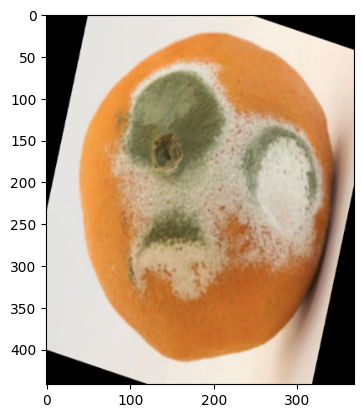

In [10]:
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[1].numpy().astype("uint8"))
  print(image_batch.shape)

In [11]:
len(dataset)

356

In [12]:
train_ds = dataset.take(int(len(dataset)*0.8))

In [13]:
len(train_ds)

284

In [14]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle, seed = 12)
  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

284
35
37


In [17]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 442, 368, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(WIDTH, HEIGHT),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [19]:
inp = (BATCH_SIZE, WIDTH, HEIGHT, CHANNELS)
n_classes = 6
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = inp),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(n_classes, activation = 'softmax')
])

In [20]:
model.build(input_shape=inp)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 442, 368, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 442, 368, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 440, 366, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 220, 183, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 218, 181, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 109, 90, 64)         0         
 g2D)                                                 

In [22]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
epoch_fit_model = model.fit(
    train_ds,
    epochs = 4,
    batch_size = BATCH_SIZE,
    validation_data = val_ds
)

Epoch 1/4
204/284 [====================>.........] - ETA: 14:54 - loss: 1.9376 - accuracy: 0.5421

In [ ]:
model.evaluate(test_ds)

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("First Image to predict")
  plt.imshow(first_image)
  print("Actual label: ", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("Predicted Label: ", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict()
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence


In [ ]:
acc = epoch_fit_model.history['accuracy']
val_acc = epoch_fit_model.history['val_accuracy']

loss = epoch_fit_model.history['loss']
val_loss = epoch_fit_model.history['val_loss']


epochs_range  = range(2)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='training accuracy')
plt.plot(epochs_range,val_acc,label="validation accuracy")
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='training loss')
plt.plot(epochs_range, val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title('training and validation loss')
plt.show()

In [ ]:
model.save('model_py/model.h5')

In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter \
     --input_format=keras \
     model_py/model.h5 \
     model_js

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
#Output
#How to improve
#Confidence level to judge
# tensorflow -> js
# Graph

In [ ]:
tf.keras.model.save_model(model, 'my_model2.hdf5')